# INF-0044 – Generative Adversarial Networks
## Trabalho Prático

Profa. Sandra Avila (sandra@ic.unicamp.br)

Monitor: Gabriel Oliveira (g197460@dac.unicamp.br)


## Objetivo 
Neste trabalho iremos utilizar uma Rede Generativa Adversarial Condicional (*Conditional* GAN) para gerar dígitos de casas a partir do *dataset* SVHN ([Street View House Numbers](http://ufldl.stanford.edu/housenumbers)).

## Conditional GANs
GANs são formadas por duas redes (discriminador e gerador) que são treinadas simultaneamente, sem compartilhamento de pesos. O gerador é responsável por aprender a transformar um ruído aleatório em uma imagem do *dataset* de interesse, enquanto o discriminador é responsável por classificar as imagens em reais e sintéticas (geradas). Um dos grandes problemas dos modelos GANs é a falta de controle quanto aos dados gerados. 

Assim, com o objetivo de controlar o tipo de dado gerado, [Mirza et al.](https://arxiv.org/abs/1411.1784) propuseram as Redes Generativas Adversariais Condicionais. Nesse tipo de rede, o módulo gerador e o discriminador são condicionados a alguma informação extra (*e.g.*, as anotações, outra modalidade de dado), como ilustrado na Figura 1. Podemos observar que a informação condicionante ($y$) deve ser concatenada de alguma forma às entradas do gerador e do discriminador. Neste trabalho, utilizaremos a própria anotação dos dados como variável condicionante.

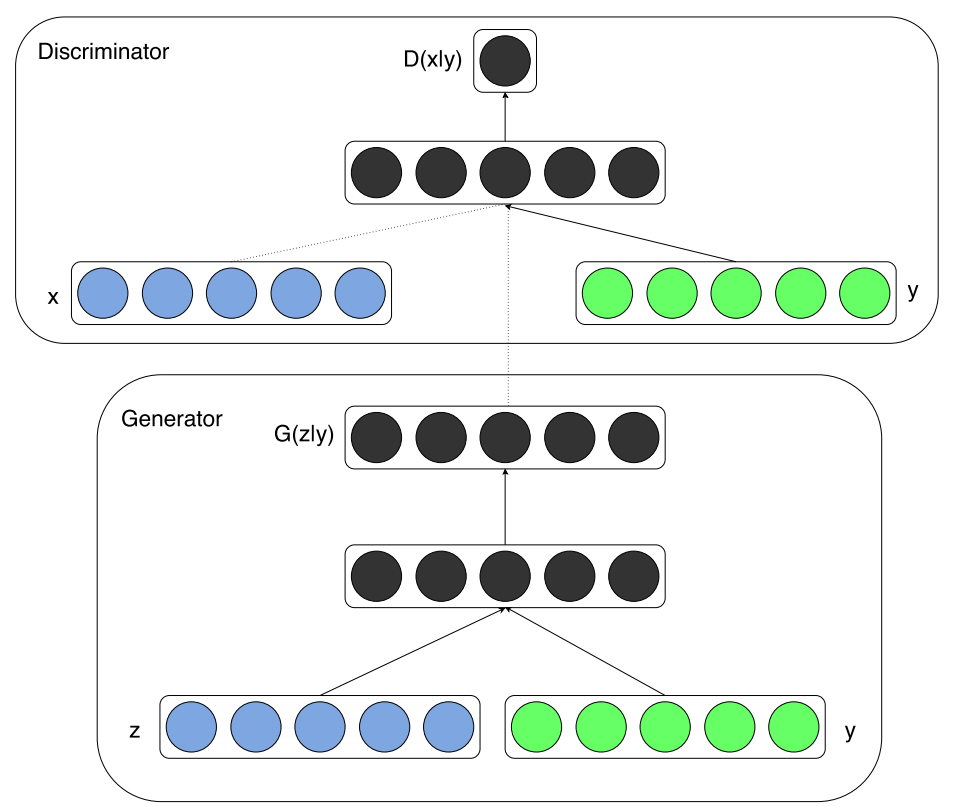

**Figura 1**: Visão geral da arquitetura das Redes Generativas Adversariais Condicionais.

## Dataset: SVHN

O *dataset* SVHN contém imagens de números de casas, já separadas (cortadas) por dígito, extraídas do Google Street View (Figura 2). O SVHN possui 73.257 imagens de treino, e 26.032 de teste, contando com 10 classes (uma para cada dígito). Para esta tarefa, faremos uma avaliação qualitativa das imagens geradas. Portanto, não utilizaremos o conjunto de teste, _apenas o conjunto de treino_. Como o SVHN é um conjunto bastante usado na literatura, ele está incorporado no `torchvision.datasets`. Assim, podemos usá-lo de maneira bastante similar ao MNIST visto nas aulas, veja a [documentação](https://pytorch.org/vision/stable/generated/torchvision.datasets.SVHN.html).

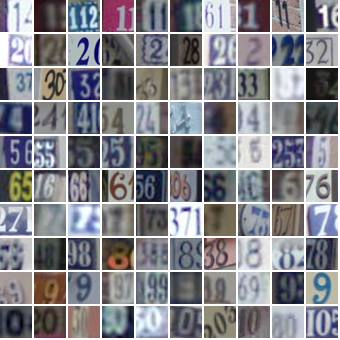

**Figura 2:** Classes e exemplos do *dataset SVHN*, cada uma em uma linha da imagem. Figura reproduzida de http://ufldl.stanford.edu/housenumbers/.

In [1]:
from tensorflow.keras import layers, activations
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

import time


ds = tfds.load('svhn_cropped', split='train', as_supervised=True, shuffle_files=True)

In [2]:
def normalize_img(image, label):
    return (tf.cast(image, tf.float32) - 127.5) / 127.5, label

def map_fn(image, label):
    return (tf.reshape(image, [-1]), label)

ds = ds.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.map(
    map_fn, num_parallel_calls=tf.data.AUTOTUNE)

ds = ds.batch(256)
ds = ds.cache()
ds = ds.shuffle(80000, reshuffle_each_iteration=True)
ds = ds.prefetch(tf.data.AUTOTUNE)
z = 128

## Atividades



1. (2.0 pontos) Altere a arquitetura apresentada na [Prática 2](https://drive.google.com/file/d/1oD7jeYD4tf33cXHGgkqL70rB3bSjem8x/view) para gerar imagens a partir do conjunto SVHN. 

* Plote a função de custo do gerador e do discriminador e o divergente de Jensen-Shannon ao longo das épocas;

* Ao final do treino, avalie a qualidade dos exemplos gerados usando a métrica Fréchet Inception Distance (FID);

* Plote um grid com alguns exemplos gerados.

Analise criticamente os resultados (Escreva 1-2 parágrafos sobre os resultados).

In [3]:
def make_generator_model():
    input_ = layers.Input(shape=(z,))
    x = layers.Dense(128)(input_)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(0.2)(x)
    out = layers.Dense(32*32*3, activation="tanh")(x)

    model = tf.keras.Model(input_, out, name="generator")
    return model

In [4]:
def make_discriminator_model():
    input_ = layers.Input(shape=(32*32*3,))

    x = layers.Dense(1024)(input_)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    
    model = tf.keras.Model(input_, out, name="discriminator")

    return model

In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = (real_loss + fake_loss) *0.5
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(3e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(3e-4)


In [6]:
EPOCHS = 200
BATCH_SIZE = 256


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, z])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss


In [7]:
generator = make_generator_model()
discriminator = make_discriminator_model()

gen_images = []
seed = tf.random.normal([10, z])

g_loss = []
d_loss = []
def train(dataset, epochs):
    count = 0
    for epoch in range(epochs):
        g = []
        d = []
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch[0])
            g.append(gen_loss.numpy())
            d.append(disc_loss.numpy())
        g_loss.append(np.average(g))
        d_loss.append(np.average(d))
        count += 1
        if count == EPOCHS//10:
            count = 0
            gen_images.append(generator(seed).numpy().reshape(-1, 32, 32, 3))
            print("g_loss: {}, d_loss: {}".format(np.average(g), np.average(d)))

        
a = time.time()
train(ds, EPOCHS)
print(time.time() - a)

g_loss: 2.6303703784942627, d_loss: 0.327628493309021
g_loss: 2.65763521194458, d_loss: 0.2960986793041229
g_loss: 2.2562673091888428, d_loss: 0.33681872487068176
g_loss: 1.9177780151367188, d_loss: 0.3498847782611847
g_loss: 1.990380048751831, d_loss: 0.3554166555404663
g_loss: 2.045400381088257, d_loss: 0.3416958451271057
g_loss: 1.993564248085022, d_loss: 0.3874240219593048
g_loss: 2.1755638122558594, d_loss: 0.39252573251724243
g_loss: 1.9720524549484253, d_loss: 0.4247463345527649
g_loss: 2.1801838874816895, d_loss: 0.4010609984397888
795.5850005149841


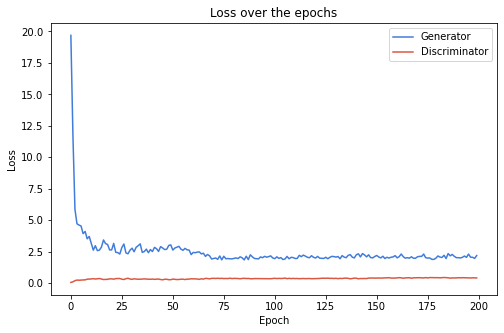

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(g_loss, color='#407cdb', label='Generator')
ax.plot(d_loss,color='#db5740', label='Discriminator')

ax.legend(loc='upper left')
handles, labels = ax.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
ax.legend(lgd.values(), lgd.keys())

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over the epochs')
plt.show()

10
(10, 32, 32, 3)


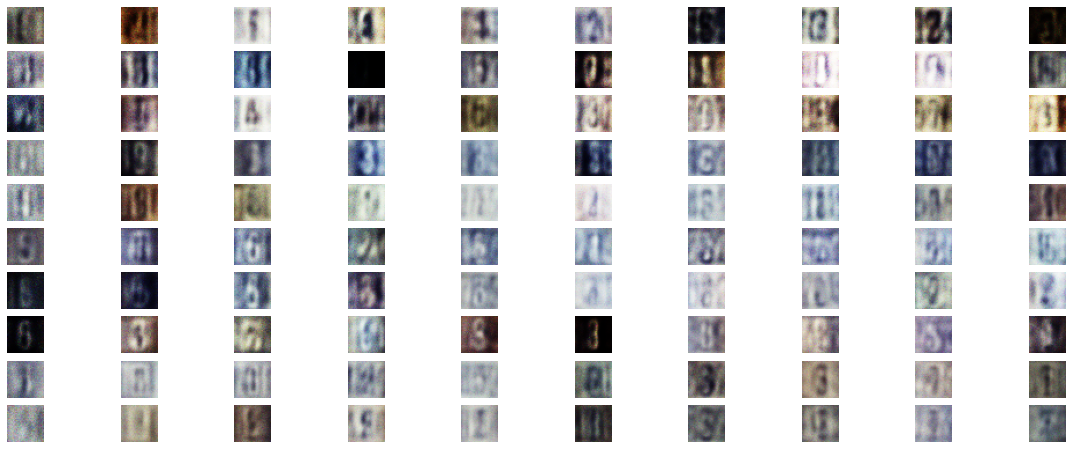

In [9]:
print(len(gen_images))
print(gen_images[0].shape)

fig, axes = plt.subplots(10, 10, figsize=(20, 8))
for i, batch in enumerate(gen_images):
    for j, img in enumerate(batch):
        axes[j][i].axis("off")
        axes[j][i].imshow((img+1)/2) # tanh out has [-1, 1] interval, convert to [0, 1]        

10
(10, 32, 32, 3)


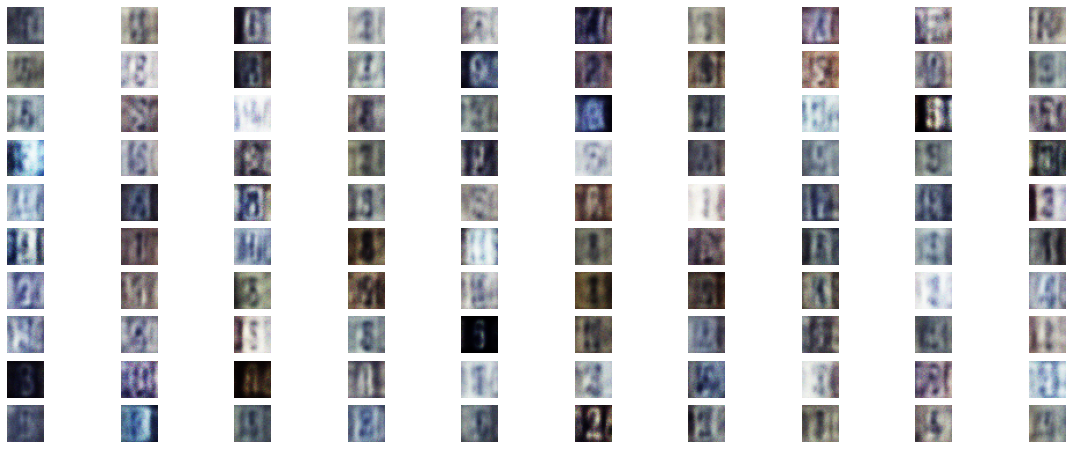

In [10]:
print(len(gen_images))
print(gen_images[0].shape)

gen_images = [generator(tf.random.normal([10, z])).numpy().reshape(-1, 32, 32, 3) for i in range(10)]


fig, axes = plt.subplots(10, 10, figsize=(20, 8))
for i, batch in enumerate(gen_images):
    for j, img in enumerate(batch):
        axes[j][i].axis("off")
        axes[j][i].imshow((img+1)/2) # tanh out has [-1, 1] interval, convert to [0, 1]     

##Prazo e Submissão

O trabalho é em dupla ou em trio e a entrega deve ser feita até dia 23/10/2022 (Domingo, 23h59). Apenas uma pessoa da equipe deve submeter o código no Jupyter Notebook.